# SONAR

Ce notebook nécessite les fichiers `sonar.py` et `impulses.npz`.
La distance à un réflecteur est estimée en mesurant le retard entre une impulsion émise et sa réflexion.

Le but du notebook est de tester différentes manières d'atténuer l'effet du bruit dans l'estimation de la distance.

In [12]:
#%matplotlib inline

#%matplotlib widget

#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
import scipy.signal as si

import sonar

impulses = np.load('impulses.npz')

## Simulations

**Q 3** On commence par simuler quelques signaux. Le point rouge indique le maximum de l'intercorrélation.

Cas non bruité :


100


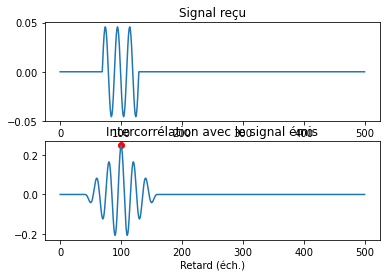

In [16]:
impulse = impulses['sines']

sig0 = sonar.sonar(impulse, variance = 0)
crl = si.correlate(sig0, impulse, mode='same')
idxmax = np.argmax(crl)

plt.figure()
plt.subplot(211)
plt.title("Signal reçu")
plt.plot(sig0)
plt.xlabel('Temps (éch.)')
plt.subplot(212)
plt.plot(crl)
plt.title("Intercorrélation avec le signal émis")
plt.scatter(idxmax, crl[idxmax], c='r');
plt.xlabel('Retard (éch.)');

print(idxmax)

Cas modérément bruité :

101


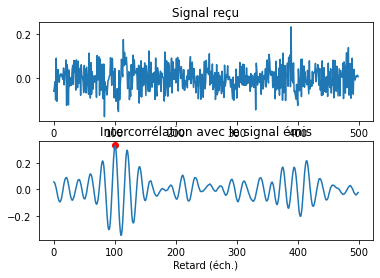

In [23]:
sig0 = sonar.sonar(impulse, variance = 0.004)
crl = si.correlate(sig0, impulse, mode='same')
idxmax = np.argmax(crl)

plt.figure()
plt.subplot(211)
plt.title("Signal reçu")
plt.plot(sig0)
plt.xlabel('Temps (éch.)')
plt.subplot(212)
plt.plot(crl)
plt.title("Intercorrélation avec le signal émis")
plt.scatter(idxmax, crl[idxmax], c='r');
plt.xlabel('Retard (éch.)');

print(idxmax)

Cas très bruité :

264


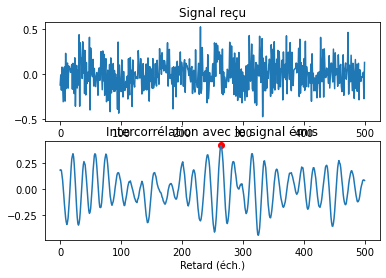

In [25]:
sig0 = sonar.sonar(impulse, variance = 0.04)
crl = si.correlate(sig0, impulse, mode='same')
idxmax = np.argmax(crl)

plt.figure()
plt.subplot(211)
plt.title("Signal reçu")
plt.plot(sig0)
plt.xlabel('Temps (éch.)')
plt.subplot(212)
plt.plot(crl)
plt.title("Intercorrélation avec le signal émis")
plt.scatter(idxmax, crl[idxmax], c='r');
plt.xlabel('Retard (éch.)');
print(idxmax)

## Moyennage

On propose de moyenner les signaux mesurées pour plusieurs impulsions.

**Q 5** Comment cette technique aide-t-elle l'estimation ? La tester avec plusieurs valeurs de répétition.

100


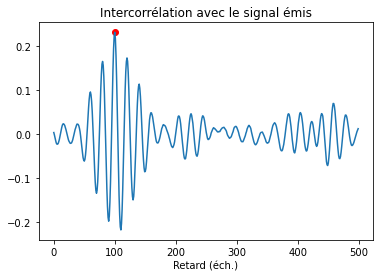

In [30]:
Ntirs = 100
impulse = impulses['sines']

sig = sonar.sonar(impulse)
corr = np.zeros(sig.shape[0])
delays = np.arange(sig.shape[0])

for tir in range(Ntirs):
    sig = sonar.sonar(impulse,variance=0.04)
    output = np.correlate(sig, impulse, mode='same')
    corr = corr + output
    
corr = corr/Ntirs

idxmax = np.argmax(corr)
print(idxmax)

plt.figure()

plt.plot(delays,corr);
plt.title("Intercorrélation avec le signal émis")
plt.xlabel('Retard (éch.)');
plt.scatter(idxmax, corr[idxmax], c='r' );


## Étude du bruit

On commence par étudier le bruit en estimant sa densité spectrale de puissance. Le code ci-dessous trace le périodogramme d'un signal de bruit, mesuré par le système SONAR sans émission d'impulsion.

**Q 6** Le périodogramme est-il une bonne estimation de la DSP du bruit ? Proposer une amélioration de l'estimation. On pourra considérer que des mesures successives du bruit sont indépendantes.


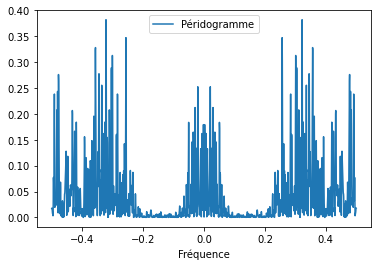

In [6]:


Nfft = 2000

nu_fft = np.arange(Nfft)/Nfft - 1/2;

sig = sonar.sonar_passif()
PSD = np.abs( fft.fft(sig, Nfft) )**2 / sig.shape[0]

plt.figure()
plt.plot(nu_fft, fft.fftshift(PSD))
plt.legend(['Péridogramme']);
plt.xlabel('Fréquence');



Périodogramme de Bartlett.

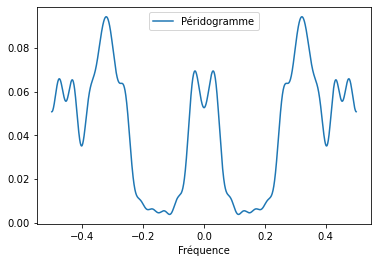

In [7]:


def bartlett(x, K):
   
    L = x.shape[0]
    Lk = L//K
    xk = np.reshape(x[:(K*Lk)], [K, Lk])
    
    return 1/(Lk * K) * np.sum(np.abs(fft.fft(xk, Nfft, axis=1))**2, axis=0)

PSD = bartlett(sig, 20)

plt.figure()
plt.plot(nu_fft, fft.fftshift(PSD))
plt.legend(['Péridogramme']);
plt.xlabel('Fréquence');


Moyennage sur plusieurs réalisations.

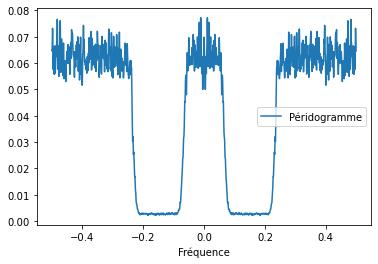

In [8]:
Nreal = 200

PSD = np.zeros([Nfft])

for k in range(Nreal):
    sig = sonar.sonar_passif()
    PSD = PSD + np.abs( fft.fft(sig, Nfft) )**2 / sig.shape[0]
    
PSD = PSD / Nreal

plt.figure()
plt.plot(nu_fft, fft.fftshift(PSD))
plt.legend(['Péridogramme']);
plt.xlabel('Fréquence');


## Choix de l'impulsion

On propose maintenant d'adapter l'impulsion aux propriétés du bruit. Le système SONAR est capable d'émettre quatre impulsions différentes, tracées en domaine temporel et fréquentielle.

**Q 6** En comparant la DSP du bruit et les spectre des impulsions, quelle impulsion paraît la plus adaptée ?


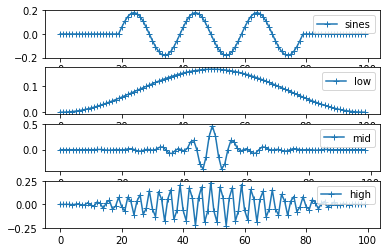

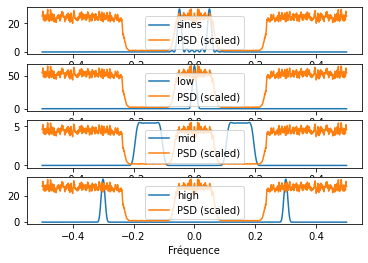

In [9]:
plt.figure

types = ['sines', 'low', 'mid', 'high']


plt.figure()

n = 0
for t in types: 
    n = n+1

    plt.subplot(410+n)
    plt.plot(impulses[t], '-+',label=t)
    plt.legend()


plt.figure()


n = 0
for t in types:
    n = n+1
    I = np.abs(fft.fft(impulses[t], Nfft))**2
    plt.subplot(410+n)
    plt.plot(nu_fft, fft.fftshift(I), label=t)
    plt.plot(nu_fft, fft.fftshift(PSD/np.amax(PSD)*np.amax(I)), label='PSD (scaled)')
    plt.legend()
   

plt.xlabel('Fréquence');


## Calcul de la variance

**Q 5** À partir de la DSP du bruit et des spectres des impulsions, calculer dans chaque cas la variance du terme perturbateur dans la corrélation. Choisir l'impulsion la plus adaptée.


In [10]:
for t in types:
    I = np.abs(fft.fft(impulses[t], Nfft))**2
    s2 = np.sum(PSD * I) / Nfft
    
    print(f"Variance de {t} : {s2:.3f}")

Variance de sines : 0.060
Variance de low : 0.060
Variance de mid : 0.003
Variance de high : 0.062


## Comparaison des résultats

**Q 6** Comparez les résultats obtenues pour les différentes impulsions et confirmer le choix fait à la question Q5.


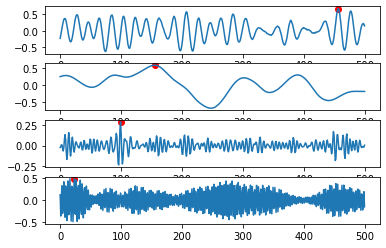

In [11]:
plt.figure()



n = 0
for t in types:
    n = n+1
    plt.subplot(410 + n)
    

    sig = sonar.sonar(impulses[t])
    output = np.correlate(sig, impulses[t], mode='same')
    plt.plot(delays, output)
    
    idxmax = np.argmax(output)

    plt.scatter(idxmax, output[idxmax], c='r')